In [1]:
###Import Packages###
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from skimage import io, color

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import re
from gensim.models import Word2Vec

In [2]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CV_Final_Project_Data/data/annot.csv', low_memory = False)

In [ ]:
df.head()

In [ ]:
# in utf8_string, get the max length from each row
def get_max_length(utf8_string):
    max_length = 0
    save_id = 0
    for i in range(len(utf8_string)):
        if len(utf8_string[i]) > max_length:
            max_length = len(utf8_string[i])
            save_id = i
    # get image_id
    image_id = df.iloc[i,0]
    return image_id, max_length
get_max_length(df['utf8_string'])

In [ ]:
# get longest word
def get_longest_word(utf8_string):
    longest_word = ''
    save_id = 0
    for i in range(len(utf8_string)):
        for word in utf8_string[i].split():
            if len(word) > len(longest_word):
                longest_word = word
                save_id = i
    # get image id from save_id from image_id column using save_id as index
    image_id = df.iloc[i,0]
    return longest_word, image_id

get_longest_word(df['utf8_string'])

In [3]:
###Functions for Pre-Process DATA###
def convert_one_channel(img):
    #some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img

In [4]:
###display some processed result to double check
fig = plt.figure(figsize = (30,7))
plt.show()

<Figure size 2160x504 with 0 Axes>

#Loader

In [5]:
def pad_img(path):
  # read image
  img = Image.open(path)
  img = np.array(img)
  old_image_height, old_image_width, channels = img.shape

  new_image_width = 1536
  new_image_height = 1536

  color = (0,0,0)
  result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

  # copy img image into upper left corner of result image
  result[0:old_image_height, 0:old_image_width] = img

  return result

In [1]:
# WHICH ONE?
# Text OCR Dataloader 
rest_set_size = 0.3
test_set_size = 0.5
class dset(Dataset):
  def __init__(self, root_dir, train=True,test=True,transformX = None, transformY = None):
        #self.pixel_file = pd.read_csv(os.path.join(root_dir, 'sample.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.test = test

        # Only useful columns are: id, width, height
        self.images_df = pd.read_csv(f'{self.root_dir}img.csv')
        # Only Useful colums are: id, image_id, bbox, utf8_string
        annotations_df = pd.read_csv(f'{self.root_dir}annot.csv')

        # process rows with puctuaitons in text
        # TODO
        
        # if data in df have same image_id, group them together
        annotations_df_grouped = annotations_df.groupby('image_id').agg(lambda x: list(x))
        
        # 70% tain, 15% valid, 15% test
        self.train_data, self.rest_data = train_test_split(annotations_df_grouped, test_size = rest_set_size, random_state = 5)
        self.validation_data, self.test_data = train_test_split(annotations_df_grouped, test_size = test_set_size, random_state = 5)

    

  # TODO: implement train, val, and test set length
  def __len__(self):
    if self.train:
      length = len(self.train_data)
    elif self.test:
      length = len(self.test_data)
    else:
      length = len(self.validation_data)
    return length
  

  # for now, this will return:
  # X: the image (padded)
  # Y: the list of bounding boxes
  def __getitem__(self, index):
    # here is how to retrieve row "names" : self.train_data.index.values[index]
    filename = ""
    if self.train:
      filename = self.train_data.index.values[index]
    elif self.test:
      filename = self.test_data.index.values[index]
    else:
      filename = self.validation_data.index.values[index]
    
    #print(f'{self.root_dir}train_val_images/train_images/{filename}.jpg')
    '''
    imx = Image.open(f'{self.root_dir}train_val_images/train_images/{filename}.jpg')
    imx = np.asarray(imx)
    # padding
    shape = imx.shape
    rows = shape[0]
    cols = shape[1]
    rows_to_add = 16 - (rows % 16)
    cols_to_add = 16 - (cols % 16)
    imx = np.pad(imx, ((0, rows_to_add), (0, cols_to_add)), 'constant')
    '''
    imx = pad_img(f'{self.root_dir}train_val_images/train_images/{filename}.jpg')
    #print(imx.shape)


    if self.train:
      annot = self.train_data.loc[filename, 'bbox']
      text = self.train_data.loc[filename, 'utf8_string']
    elif self.test:
      annot = self.test_data.loc[filename, 'bbox']
      text = self.test_data.loc[filename, 'utf8_string']
    else:
      annot = self.validation_data.loc[filename, 'bbox']
      text = self.validation_data.loc[filename, 'utf8_string']
    
    # convert text to vectors
    # print(text[0])
    # model = Word2Vec(text[0], min_count=1, batch_words=1)
    # vec_arr = []
    # for word in text[0]:
    #   vec_arr.append(model.wv[word])
    # vec_arr = np.array(vec_arr)
    
    # for each letter/digit in text, map them into an integer value between 0 to 36
    # 00-09: 0-9
    # 10-35: A-Z
    # add a 36 in between each word
    int_text = []
    new_text = re.sub(r'[^\w\s]','',str(text))
    new_text = new_text.split()
    length = len(new_text)
    n = ''
    # print(new_text, type(new_text))
    for t in new_text:
      # print(t)
      temp_text = []
      for i in range(len(t)):
        # print(t[i])
        if t[i].isdigit():
          n = int(t[i])
        elif t[i].isalpha():
          n = int(ord(t[i].upper()) - 55)
        if i == length - 1:
          n = 37
        temp_text.append(n)
      int_text.append(temp_text)
    # for i in range(length):
    #   if t[i].isdigit():
    #     n += '0' + str(t[i])
    #   elif t[i].isalpha():
    #     n += str(ord(t[i].upper()) - 55)
    #   else:
    #     n += '36'
    #   n += ' '
    #   if i == length - 1:
    #     n += '37'
    # int_text.append(n)

    # sample = {'image': imx, 'annotation': annot, 'text': vec_arr}
    sample = {'image': imx, 'annotation': annot, 'text': text, 'int_text': int_text}
    return sample

#path = '/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/train_val_images/train_images/00c359f294f7dcd9.jpg'
#img = pad_img(path)


NameError: name 'Dataset' is not defined

["['[473.11, 532.33, 21.71, 16.52]', '[495.9, 538.48, 19.45, 16.64]', '[474.54, 554.93, 36.7, 25.5]', '[312.02, 488.62, 22.97, 18.27]', '[334.99, 493.33, 22.86, 20.1]', '[432.58, 269.77, 126.97, 45.09]']"]
["['NYC', 'TAXI', '1H53', 'TAXI', 'FAKE', 'WEATHERPROOF']"]


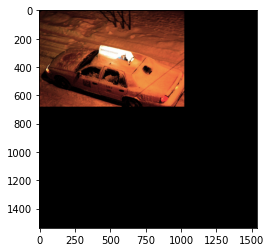

In [ ]:
# OCRdata = dset('/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/', train=True,test=False,)
OCRdata = dset('/content/drive/MyDrive/CV_Final_Project_Data/data/')
data = OCRdata.__getitem__(1)

plt.imshow(data['image'])
print(data['annotation'])
print(data['text'])

In [16]:
#test
OCRdata.train_data.index.values[0]

'0868e18f64b83259'

In [17]:
###initialize data_loaders
tx_X = transforms.Compose([transforms.ToTensor(),
              transforms.Normalize((0.5,), (0.5,))])
tx_Y = transforms.Compose([transforms.ToTensor()
                        ])

# train_data = dset('/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/', train=True, test=False, transformX = tx_X, transformY = tx_Y)
# validation_data = dset('/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/', train=False,test=False,transformX = tx_X, transformY = tx_Y)
# test_data = dset('/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/', train=False, test=True,transformX = tx_X, transformY = tx_Y
train_data = dset('/content/drive/MyDrive/CV_Final_Project_Data/data/', train=True, test=False, transformX = tx_X, transformY = tx_Y)
validation_data = dset('/content/drive/MyDrive/CV_Final_Project_Data/data/', train=False,test=False,transformX = tx_X, transformY = tx_Y)
test_data = dset('/content/drive/MyDrive/CV_Final_Project_Data/data/', train=False, test=True,transformX = tx_X, transformY = tx_Y)

train_loader = DataLoader(dataset=train_data, batch_size=2, shuffle=True, num_workers=2)
validation_loader = DataLoader(dataset=validation_data, batch_size=2, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset=test_data, batch_size=2, shuffle=True, num_workers=1)

In [18]:
print('length')
print(len(train_loader))
print(len(validation_loader))
print(len(test_loader))

length
7612
5437
5438


#Model

In [19]:
import torch.nn as nn


class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)

        return output

In [20]:
model = CRNN(1152, 3, 37, 256)
if torch.cuda.is_available():
    model = model.to('cuda')

In [21]:
model.modules

<bound method Module.modules of CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNo

#Loss and Optimizer

In [22]:
# Using Adam as our optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # weight_decay=

In [23]:
# Using Loss()
criterion = nn.CTCLoss()

#Train and Validation (TO DO)

In [25]:
# training the model
# https://github.com/meijieru/crnn.pytorch/blob/master/train.py
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data = data.to('cuda')
            target = target.to('cuda')
        optimizer.zero_grad()
        output = model(data)
        output = output.log_softmax(2)
        output = output.permute(1, 0, 2)
        target = target.long()
        target = target.permute(1, 0)
        input_lengths = torch.full(size=(output.size(0),), fill_value=output.size(1), dtype=torch.long)
        target_lengths = torch.full(size=(target.size(0),), fill_value=target.size(1), dtype=torch.long)
        loss = criterion(output, target, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# train
for epoch in range(1, 10):
    train(model, train_loader, optimizer, criterion, epoch)

[("['Repair', 'This', 'is', 'the', 'one', 'area', 'where', 'we', 'are', 'yet', 'to', 'record', 'any', 'significant', 'progress', 'It', 'would', 'be', 'a', 'crime', 'to', 'categorise', 'me', 'as', 'any', 'sort', 'of', 'handyman', 'as', 'Jane', 'will', 'readily', 'testify', 'So', 'when', 'it', 'comes', 'to', 'mending', 'broken', 'items', 'around', 'the', 'home', 'I', 'still', 'tend', 'to', 'err', 'on', 'the', 'side', 'of', 'either', 'replacing', 'it', 'or', 'of', 'it', 'isnt', 'too', 'expensive', 'call', 'in', 'a', 'true', 'Mr', 'or', 'Mrs', 'Fixit', 'The', 'only', 'things', 'that', 'I', 'think', 'we', 'would', 'attempt', 'to', 'repair', 'ourselves', 'are', 'clothes', 'One', 'solution', 'we', 'have', 'settled', 'on', 'is', 'trying', 'to', 'think', 'more', 'carefully', 'before', 'buying', 'any', 'gadget', 'or', 'appliance', 'If', 'we', 'do', 'decide', 'that', 'we', 'need', 'it', 'we', 'now', 'research', 'it', 'beforehand', 'and', 'source', 'goods', 'that', 'have', 'a', 'good', 'reputation

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa275c05f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1474, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


[("['FLIGHT', 'IN', 'ON', 'BEST', 'OF', 'THE', 'NATIONAL', 'FAT', 'BACK', 'BAND', 'MOTION', 'ONS', 'FROM', 'THE', 'ORIGINAL', 'NATIONAL', 'SHALAMARTHE', 'LOOK', 'KOOL', 'PICTURE', 'THE', 'HAROLD', 'SOUNDTRACK', 'AND', 'THE', 'WOMAN', 'IN', 'RED', 'NOTES', 'THE', 'BLUE', 'GANG', 'IN', 'THE', 'SLADE', 'PHILLYBUSTERS', 'HEART', 'AT', 'SLADEST', 'LI', 'AD', 'WILD', 'AND', 'HOT', 'CHOCOLATE', 'PEACEFUL', 'SIX', 'GREATEST', 'Cicero', 'THE', 'GANG', 'KOOL', 'The', 'Sound', 'of', 'Philadelphia', 'PIR', '65659', 'POLYDOR', 'SUPER', 'DELITE', 'RECO', 'ELEKTRA', 'RECORDS', 'K42115', 'SRAK', '307', 'STEREO', '22', 'SRA', 'ParkHot', 'Chocolate', 'ATLANTIC', 'RECORDS', 'K', '50565', 'STAX', 'RECORDS', 'ABC', 'RECORDS', 'ABCE', '5121', 'STX', '1005', 'IE', 'GOES', 'CHILDREN', 'TO', 'HOLLYWOOD', 'WELCOME', 'HITS', 'TO', 'THE', 'PLEASUREDOME', 'DRAMATICS', 'THE', 'DRAMATIC', 'JACKPOT', 'M', 'HOT', 'AUGUST', 'NIGHT', 'NEIL', 'DIAMOND', 'YOUVE', 'LOU', 'THE', 'BEST', 'LOU', 'RAWLS', 'OF', 'BLONDIE', 'SIM

In [ ]:
# validation
def validation(model, validation_loader, criterion):
    model.eval()
    validation_loss = 0
    for i, item, in enumerate(validation_loader):
        if torch.cuda.is_available():
            item['image'] = item['image'].to('cuda')
            item['text'] = item['text'].to('cuda')
        # convert text to int, image to float tensor
        item['image'] = item['image'].type(torch.FloatTensor)
        item['text'] = item['text'].type(torch.LongTensor)
        # forward pass
        output = model(item['image'])
        output = output.permute(1, 0, 2)
        output = output.log_softmax(2)
        output = output.permute(1, 0, 2)
        # calculate loss
        loss = criterion(output, item['text'], torch.IntTensor([output.size(0)] * item['image'].size(0)), torch.IntTensor([item['text'].size(0)] * item['image'].size(0)))
        validation_loss += loss.item()
    print('Validation Loss: {}'.format(validation_loss / len(validation_loader)))

In [ ]:
# testing
def test(model, test_loader):
    model.eval()
    for i, item, in enumerate(test_loader):
        if torch.cuda.is_available():
            item['image'] = item['image'].to('cuda')
            item['text'] = item['text'].to('cuda')
        # convert text to int, image to float tensor
        item['image'] = item['image'].type(torch.FloatTensor)
        item['text'] = item['text'].type(torch.LongTensor)
        # forward pass
        output = model(item['image'])
        output = output.permute(1, 0, 2)
        output = output.log_softmax(2)
        output = output.permute(1, 0, 2)
        # calculate loss
        loss = criterion(output, item['text'], torch.IntTensor([output.size(0)] * item['image'].size(0)), torch.IntTensor([item['text'].size(0)] * item['image'].size(0)))
        print('Test Loss: {}'.format(loss.item()))

In [ ]:
# # old
# from tqdm.notebook import tqdm
# def train(model, criterion, epochs = 5, verbose=False):
#   if not train_hist:
#     train_hist = []
#   if not val_hist:
#     val_hist = []
    
#   torch.cuda.empty_cache()
    
#   tqdm.write("====== Training Started ======")
#   epochs_completed = 0
#   for e in tqdm(range(epochs), position=0, desc="Epochs", leave=False, colour='green'):
#     train_running_loss = 0.0
#     validation_running_loss = 0.0
#     ct = 0.0
    
#     model.train()
    
#     # print("Losses are reset to:", train_running_loss, validation_running_loss, ct)
#     for ith_batch, sample in tqdm(enumerate(train_loader), position=1, desc="Batches", leave=False, total=len(train_loader), colour='blue'):
#       X, Y = sample['image'], sample['annotation']

#       if torch.cuda.is_available():
#         X = X.to('cuda')
#         Y = Y.to('cuda')

#       y_pred = model(X)
#     # out = (y_pred + 0.5).int().float()
      
#       # loss = criterion(y_pred, Y) #* 0.70 + 0.30 * dice_loss(y_pred, y_train)
#       loss=0.3*dice_loss(y_pred, Y)+0.7*criterion(y_pred, Y)
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
#       if verbose and ith_batch % 10 == 0 and ith_batch != 0:
#         # print("This item's loss:", f'{loss.item()}')
#         # print("This pred started with", y_pred[0][0][0][0:10])
#         tqdm.write('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Curr Epoch Loss: ', f'{train_running_loss / ct:0.3f}')
        
#       train_running_loss += loss.item()
#       train_hist.append(loss.item())
#       ct += 1.0

In [ ]:
total_epochs=0

In [ ]:
num_epochs = 100
# and visualize the full training graph
completed_epochs = train(model, criterion, epochs=num_epochs, verbose=False)
total_epochs+=completed_epochs

In [ ]:
torch.save(model.state_dict(),'/content/best_unet_051722_v1.pth')

# Test

Once the training is completed, we just need to upload the model and run from here.

In [ ]:
# Load saved model
model = Class()
model.load_state_dict(torch.load('/content/best_unet_051722_v1.pth'))

In [ ]:
###Load DATA

test_set_size = 0.5
class dset(Dataset):
    def __init__(self, root_dir, train=True,test=True,transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'sample.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.test = test
        
        # split the dataset to train and rest
        # split the rest to validation and test
        self.train_data, self.test_data = train_test_split(self.pixel_file, test_size = test_set_size, random_state = 5)
        # self.validation_data, self.test_data = train_test_split(self.rest_data, test_size = test_set_size, random_state = 5)

    def __len__(self):
        if self.train:
          length = len(self.train_data)
        elif self.test:
          length = len(self.test_data)
        else:
          length = len(self.validation_data)
        return length
    
    def __getitem__(self, index):
        if self.train:
          imx_name = os.path.join(self.root_dir, 'original_img',self.train_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.train_data.iloc[index, 0].replace('.png','_m.png'))
        elif self.test:
          imx_name = os.path.join(self.root_dir, 'original_img',self.test_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.test_data.iloc[index, 0].replace('.png','_m.png'))
        else:
          imx_name = os.path.join(self.root_dir, 'original_img', self.validation_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.validation_data.iloc[index, 0].replace('.png','_m.png'))
        
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')

        if self.transformX:
            imx = self.transformX(imx)
            imy = self.transformY(imy)
      
        sample = {'image': imx, 'annotation': imy}
        return sample

In [ ]:
tx_X = transforms.Compose([ transforms.Resize((512, 512)),
                              transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                              ])
tx_Y = transforms.Compose([ transforms.Resize((512, 512)),
                              transforms.ToTensor()
                              ])
train_data = dset('/content/data', train=True, test=False, transformX = tx_X, transformY = tx_Y)
test_data = dset('/content/data', train=False, test=True,transformX = tx_X, transformY = tx_Y)

train_loader = DataLoader(dataset=train_data, batch_size=2, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_data, batch_size=2, shuffle=True, num_workers=1)

In [ ]:
#test
def avg_dice_index(dataloader): 
    dice = 0.0
    model.eval()
    with torch.no_grad():
        for ith_batch, sample_batched in enumerate(dataloader):
  
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['annotation'].to('cuda')
            
            y_predict = (model(X_train) + 0.5).int().float()
            
            dice += dice_index(y_predict, y_train)
            
    print(len(dataloader))
    avg_dice = dice / len(dataloader)
    
    return avg_dice.item()

In [ ]:
test_score=avg_dice_index(test_loader)

29


In [ ]:
print('Avergae Dice Score is:',test_score)
print('Avergae Dice Loss is:',1-test_score)

Avergae Dice Score is: 0.9117302298545837
Avergae Dice Loss is: 0.08826977014541626


#Post-Process